# Data Exploration

In [1]:
import pandas as pd

from DevelopedMethods.DF import *  # import np, pd, sklearn fn's --and df (https://www.kaggle.com/datasets/andrewmvd/heart-failure-clinical-data)

In [2]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


**notice <u>all numerical</u> features:**

**binary:** *smoking, sex, high_blood_pressure, diabetes, anaemia*

**non-binary:** *age, creatinine_phosphokinase, ejection_fraction, platelets, serum_creatinine, serum_sodium, time*

## Feature Matrix (X) & Target/label Vector (y)

In [4]:
X = df.iloc[:, :-1]
y = df['DEATH_EVENT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Check for imbalance

In [117]:
tmp = pd.concat([y.value_counts(), y.value_counts(normalize=True), y_train.value_counts(), y_train.value_counts(normalize=True)], axis=1)
tmp.columns = ['DF DEATH_EVENT', f'DF ({len(y)})    %', 'y_train DEATH_EVENT', f'y_train ({len(y_train)})   %']
tmp

,DF DEATH_EVENT,DF (299) %,y_train DEATH_EVENT,y_train (239) %
DEATH_EVENT,,,,
0,203,0.67893,168,0.702929
1,96,0.32107,71,0.297071


#### Mild imbalance. Explore SMOTE, weighted loss functions, or threshold tuning.
1. **SMOTE (Synthetic Minority Over-sampling Technique):** This technique generates synthetic samples for the minority class (DEATH_EVENT) to balance the dataset. It's effective but can introduce noise.
1. **Weighted Loss Functions:** higher weights to minority class **during training**. This approach helps the model focus more on correctly predicting the minority class without altering the dataset.
1. **Threshold Tuning:** Adjust the decision threshold of your model's predictions to improve sensitivity for the minority class. This is useful **after model training**.

In [122]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
y_resampled.value_counts()

DEATH_EVENT
1    168
0    168
Name: count, dtype: int64

Detect SMOTE Noise

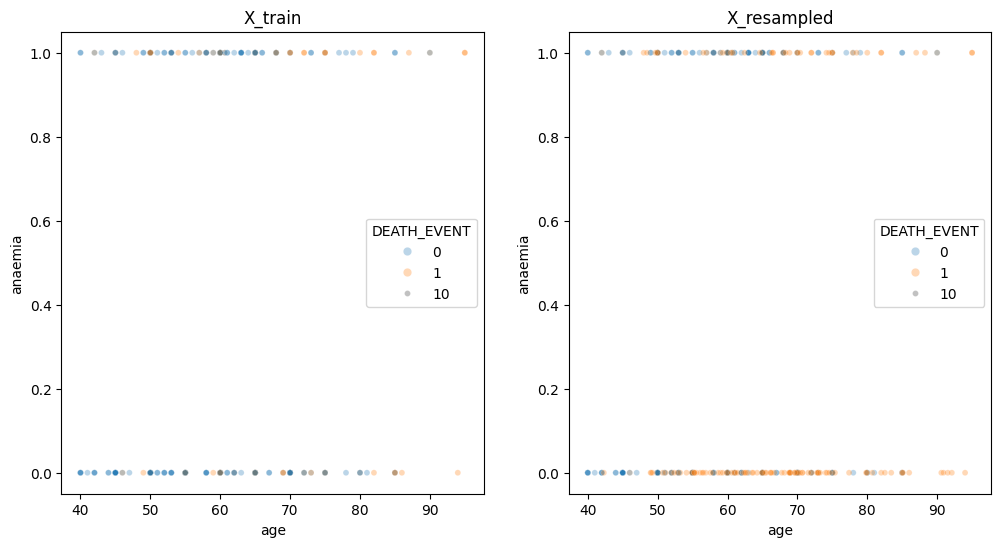

In [146]:
# fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# ROC Curves subplot
axes[0].set_title("X_train")
sns.scatterplot(x=X_train.iloc[:, 0], y=X_train.iloc[:, 1], hue=y_train, size=10, alpha=0.3, ax=axes[0])

axes[1].set_title('X_resampled')
# axes[1].legend(*scatter.legend_elements(), title="Clusters")
sns.scatterplot(x=X_resampled.iloc[:, 0], y=X_resampled.iloc[:, 1], hue=y_resampled, size=10, alpha=0.3, ax=axes[1])

plt.show()

handle SMOTE noise:
```
 1 Use a Smaller k-Nearest Neighbors (k): When generating synthetic samples,
   use a smaller value for k (e.g., k=3) to reduce the influence of distant
   neighbors.
 2 Combine with Undersampling: Use SMOTE in conjunction with undersampling
   the majority class to reduce the overall dataset size and potential noise.
 3 Outlier Detection: Apply outlier detection techniques (e.g., Isolation
   Forest, DBSCAN) to identify and remove noisy samples before applying
   SMOTE.
 4 Evaluate Model Robustness: After training, validate your model using
   cross-validation and check performance metrics to ensure it generalizes
   well despite potential noise.```

DEATH_EVENT
1    168
0    168
Name: count, dtype: int64

## Attempt PCA

In [6]:
corr = df.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap="BuPu",
            vmin=-1,
            vmax=1,
            annot=True)
plt.title("Correlation Heatmap")
plt.show()
##%% md

compare SVM vs. ANN across different metrics (AUC-ROC, precision-recall, F1-score)
- find Hyperparameters – Grid search, random search, or Bayesian optimization

???Using SHAP or LIME to explain predictions???


"1 SMOTE (Synthetic Minority Over-sampling Technique): This technique generates synthetic samples for the minority class (DEATH_EVENT) to balance the dataset. It's effective but can introduce noise.\n 2 Weighted Loss Functions: Assign higher weights to the minority class during model training. This approach helps the model focus more on correctly predicting the minority class without altering the dataset.\n 3 Threshold Tuning: Adjust the decision threshold of your model's predictions to improve sensitivity for the minority class. This is useful after model training."

In [ ]:
##%%
